In [1]:
import tensorflow as tf
import numpy as np
import gym
from ou_noise import OUNoise
import matplotlib.pyplot as plt
import random

LAYER_1 = 400
LAYER_2 = 300
LAYER_3 = 300
keep_rate = 0.8
LAMBDA = 0.00001 # regularization term
GAMMA = 0.99
class DDPG(object):


    def __init__(self, sess, state_dim, action_dim, max_action, min_action, actor_learning_rate, critic_learning_rate, tau, RANDOM_SEED, device = '/cpu:0'):

        self.sess = sess
        np.random.seed(RANDOM_SEED)
        tf.set_random_seed(RANDOM_SEED)
        self.s_dim = state_dim
        self.a_dim = action_dim
        self.actor_learning_rate = actor_learning_rate
        self.critic_learning_rate = critic_learning_rate
        self.tau = tau
        self.device = device
        self.max_action = max_action
        self.min_action = min_action
        # Placeholders
        self.inputs = tf.placeholder(tf.float32, shape=[None, self.s_dim], name='state')
        self.action = tf.placeholder(tf.float32, shape=[None, self.a_dim], name='actions')
        scope = 'net'    
        self.v, self.a, self.scaled_a, self.saver = self._build_net(scope)
        self.a_params = tf.trainable_variables(scope=scope + '/actor')
        self.c_params = tf.trainable_variables(scope=scope + '/critic')
        #self.a_params = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope=scope + '/actor')
        #self.c_params = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope=scope + '/critic')
        scope = 'target'    
        self.v_target, self.a_target, self.scaled_a_target, self.saver_target = self._build_net(scope)
        self.a_params_target = tf.trainable_variables(scope=scope + '/actor')
        self.c_params_target = tf.trainable_variables(scope=scope + '/critic')
        #self.a_params_target = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope=scope + '/actor')
        #self.c_params_target = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope=scope + '/critic')

        
        with tf.variable_scope('learning_rate'): 
            # global step
            self.global_step = tf.Variable(0, trainable=False)
            self.actor_decay_learning_rate = tf.train.exponential_decay(self.actor_learning_rate, self.global_step, 100000, 0.96, staircase=True)
            self.critic_decay_learning_rate = tf.train.exponential_decay(self.critic_learning_rate, self.global_step, 100000, 0.96, staircase=True)
        
        with tf.device(self.device):
            # Op for periodically updating target network with online network
            # weights with regularization
            self.generate_param_updater()
           
            self.predicted_q_value = tf.placeholder(tf.float32, [None, 1])
            # Define loss and optimization Op
            self.squared = tf.square(tf.subtract(self.predicted_q_value,self.v))
            self.l2_loss = tf.losses.get_regularization_loss(scope="net/critic")
            self.loss = tf.reduce_mean(self.squared) + self.l2_loss 
            self.critic_optimize = tf.train.AdamOptimizer(self.critic_decay_learning_rate).minimize(self.loss, global_step=self.global_step) 
            self.action_grads = tf.gradients(self.v, self.action)[0]
            self.actor_gradients = tf.gradients(self.a, self.a_params, -self.action_grads)
            self.actor_optimize = tf.train.AdamOptimizer(self.actor_decay_learning_rate).apply_gradients(zip(self.actor_gradients, self.a_params), global_step=self.global_step)
            
            # inverting gradients
            self.inverting_gradients_placeholder = tf.placeholder(tf.float32, shape=[None, self.a_dim], name='inverting_gradients')
            self._dq_da = tf.gradients(self.v, self.action)[0] # q, a 
            self._grad = tf.gradients(self.a, self.a_params, -self.inverting_gradients_placeholder)
            self._train_actor = tf.train.AdamOptimizer(self.actor_decay_learning_rate).apply_gradients(zip(self._grad, self.a_params),global_step=self.global_step)
            
            


    def _build_net(self,scope):
       
        with tf.device(self.device):        
            with tf.variable_scope(scope + '/critic'):
                
                
                '''
                net = tf.layers.dense(self.inputs, LAYER_1, tf.nn.relu, name='critic_L1')
                initializer = tf.variance_scaling_initializer()
                s_union_weights = tf.Variable(initializer.__call__([LAYER_1, LAYER_2]), name='critic_L2_Ws')
                a_union_weights = tf.Variable(initializer.__call__([self.a_dim, LAYER_2]), name='critic_L2_Wa')
                union_biases = tf.Variable(tf.zeros([LAYER_2]), name='critic_L2_b')
                net = tf.nn.relu(tf.matmul(net, s_union_weights) + tf.matmul(self.action, a_union_weights) + union_biases,name='critic_L2')
                w_init = tf.random_uniform_initializer(minval=-0.003, maxval=0.003)
                v = tf.layers.dense(net, self.a_dim, kernel_initializer=w_init, name='critic_output')
                '''
                regularizer = tf.contrib.layers.l2_regularizer(scale=LAMBDA)
                l1 = tf.contrib.layers.fully_connected(self.inputs, LAYER_1, weights_regularizer=regularizer, activation_fn=tf.nn.leaky_relu)
                l2_a = tf.contrib.layers.fully_connected(self.action, LAYER_2, weights_regularizer=regularizer, activation_fn=None)
                l2_s = tf.contrib.layers.fully_connected(l1, LAYER_2, weights_regularizer=regularizer,activation_fn=None)
                l2 = tf.nn.leaky_relu(l2_s + l2_a)
                v = tf.contrib.layers.fully_connected(l2, 1, weights_regularizer=regularizer, activation_fn=None)
                
            with tf.variable_scope(scope + '/actor'):
                l1 = tf.contrib.layers.fully_connected(self.inputs, LAYER_1,  activation_fn=tf.nn.leaky_relu) # tf.nn.leaky_relu tf.nn.relu
                l2 = tf.contrib.layers.fully_connected(l1, LAYER_2,  activation_fn=tf.nn.leaky_relu)
                w_init = tf.random_uniform_initializer(minval=-0.003, maxval=0.003)
                a = tf.contrib.layers.fully_connected(l2, self.a_dim, weights_initializer=w_init, activation_fn=tf.nn.tanh) # (para el ddpg)
                #a = tf.contrib.layers.fully_connected(l2, self.a_dim, weights_initializer=w_init, activation_fn=None) # (para el inverted)
                scaled_a = a
                # scaled_a = tf.clip_by_value(a,self.min_action,self.max_action)#tf.multiply(a, self.action_bound)
                       
        saver = tf.train.Saver()
        return v, a, scaled_a, saver

    def train(self, s_batch, a_batch, r_batch, t_batch, s2_batch, MINIBATCH_SIZE):
        
        
        # get q target
        target_q = self.critic_predict_target(s2_batch, self.predict_action_target(s2_batch))
        # obtain y
        y_i = []
        for k in range(MINIBATCH_SIZE):
            if t_batch[k]:
                y_i.append(r_batch[k])
            else:
                y_i.append(r_batch[k] + GAMMA * target_q[k])
        # train critic
        LOSS = self.critic_train(s_batch, a_batch, np.reshape(y_i, (MINIBATCH_SIZE, 1)))
        # print(L2_LOSS)
        a_outs = self.predict_action(s_batch)
        self.actor_train(s_batch, a_outs)
        
        self.update_target_network()

        return

    def test_gradient(self, s_batch, a_batch, r_batch, t_batch, s2_batch, MINIBATCH_SIZE):
        
        
        # get q target
        target_q = self.critic_predict_target(s2_batch, self.predict_action_target(s2_batch))
        # obtain y
        y_i = []
        for k in range(MINIBATCH_SIZE):
            if t_batch[k]:
                y_i.append(r_batch[k])
            else:
                y_i.append(r_batch[k] + GAMMA * target_q[k])
        
        # train critic
        LOSS = self.critic_train(s_batch, a_batch, np.reshape(y_i, (MINIBATCH_SIZE, 1)))
        # train critic
        #ac_tor_grads = self._critic_train(s_batch, a_batch, np.reshape(y_i, (MINIBATCH_SIZE, 1)))
        #print('a grads',ac_tor_grads)
        actions = self.predict_action(s_batch)
        
        upper = self.max_action
        lower = self.min_action

        # get dq/da array, action array
        #print(upper, '***************')
        dq_das = self.sess.run([self._dq_da], feed_dict={self.inputs: s_batch, self.action:actions})[0]
        # inverting gradients, if dq_da >= 0, apply upper method, else lower method
        inverting_gradients = []
        #'''
        # print('1 dq_das, actions',dq_das, actions)
        '''
        # print('dq_das, actions',dq_das, actions)
        for dq_da, action in zip(dq_das, actions):
            # print('dq_da, action',dq_da, action)
            if dq_da >= 0.0:
                inverting_gradients.append(dq_da * (self.max_action - action) / (self.max_action - self.min_action))
            else:
                inverting_gradients.append(dq_da * (action - self.min_action) / (self.max_action - self.min_action))
        inverting_gradients = np.array(inverting_gradients).reshape(-1, 1)
        '''

        for i in range(MINIBATCH_SIZE):
            #print('2', i,dq_das[i])
            for j in range(self.a_dim):
                if dq_das[i][j] >= 0.0:
                    dq_das[i][j] = dq_das[i][j] * (self.max_action - actions[i][j]) / (self.max_action - self.min_action)
                else:
                    dq_das[i][j] = dq_das[i][j] * (actions[i][j] - self.min_action) / (self.max_action - self.min_action)
        
        # print(dq_das,inverting_gradients)
        # exit()
        inverting_gradients = dq_das 
        
        # print('2 dq_das, actions',dq_das, actions)
        
         
        #print('1','inverting_gradients',inverting_gradients)
        
        # print('2','inverting_gradients',inverting_gradients,dq_das, actions)
        # time.sleep(1)
        # update actor
        self.sess.run(self._train_actor, feed_dict={self.inputs: s_batch, self.inverting_gradients_placeholder: inverting_gradients})
        self.update_target_network()
        return

    
    def _critic_train(self, inputs, action, predicted_q_value):
        return self.sess.run([self.action_grads], feed_dict={
            self.inputs: inputs,
            self.action: action,
            self.predicted_q_value: predicted_q_value
        })


    def update_target_network(self):
        self.sess.run([self.a_updater,self.c_updater])

    def generate_param_updater(self):
        self.a_updater = [self.a_params_target[i].assign(tf.multiply(self.a_params[i], self.tau) + tf.multiply(self.a_params_target[i], 1. - self.tau))
                for i in range(len(self.a_params))]
        self.c_updater = [self.c_params_target[i].assign(tf.multiply(self.c_params[i], self.tau) + tf.multiply(self.c_params_target[i], 1. - self.tau))
                for i in range(len(self.c_params))]

    def critic_train(self, inputs, action, predicted_q_value):
        return self.sess.run([self.loss,self.critic_optimize], feed_dict={
            self.inputs: inputs,
            self.action: action,
            self.predicted_q_value: predicted_q_value
        })


    def actor_train(self,inputs, action):
        return self.sess.run(self.actor_optimize, feed_dict={
            self.inputs: inputs,
            self.action: action
        })

    def save(self):
        self.saver.save(self.sess,"./model/model.ckpt")
        self.saver_target.save(self.sess,"./model/model_target.ckpt")
        print("Model saved in file: actor_model")

    
    def load(self):
        self.saver.restore(self.sess,"./model/model.ckpt")
        self.saver_target.restore(self.sess,"./model/model_target.ckpt")
        


    def critic_predict_target(self, state, action):
        return self.sess.run(self.v_target, feed_dict={
            self.inputs: state,
            self.action: action
        })
        
    def predict_action_target(self, state):
        return self.sess.run(self.scaled_a_target, feed_dict={
            self.inputs: state
        })

    def predict_action(self, state):
        return self.sess.run(self.scaled_a, feed_dict={
            self.inputs: state
        })



class graficos(object):


    def __init__(self,init_state,Temp_0,Irr_0,accion_0=0.):

        v=init_state[0]
        self.V = list([v])
        p=init_state[1]
        self.P = list([p])
        #deltav=init_state[2]
        #self.deltaV = list([deltav])
        self.I = list([0.])
        self.Temp = list([Temp_0])
        self.Irr = list([Irr_0])
        self.acciones = list([accion_0])
        
    def add(self,v,p,i,T,irr,accion):
        #add(self,v,p,dv,i,T,irr,accion):
        self.V.append(v)
        self.P.append(p)
        #self.deltaV.append(dv)
        self.I.append(i)
        self.Temp.append(T)
        self.Irr.append(irr)
        self.acciones.append(accion)



    def plotear(self):
        plt.plot(self.V,self.P)
        plt.xlabel('V (v)')
        plt.ylabel('P (w)')
        plt.title('V-P curve')
        plt.savefig('VPcurve' + '.png')
        plt.show()

        plt.plot(self.V,self.I)
        plt.xlabel('V (v)')
        plt.ylabel('I (A)')
        plt.title('V-I curve')
        plt.savefig('VIcurve' + '.png')
        plt.show()


        plt.plot(self.V)
        plt.xlabel('Time (sec)')
        plt.ylabel('V (volts)')
        plt.savefig('Tesion' + '.png')
        plt.show()

        plt.plot(self.I)
        plt.xlabel('Time (sec)')
        plt.ylabel('I (amperes)')
        plt.savefig('Corriente' + '.png')
        plt.show()

        plt.plot(self.P)
        plt.xlabel('Time (sec)')
        plt.ylabel(' Power (Watts)')
        #plt.title('Power')
        plt.savefig('Potencia' + '.png')
        plt.show()

        plt.plot(self.acciones,'.')
        plt.xlabel('Time (sec)')
        plt.ylabel('')
        plt.title('Manipulated actions')
        plt.ylim(-10,10)
        plt.savefig('Acciones' + '.png')
        plt.show()

        plt.plot(self.Temp)
        plt.xlabel('Time')
        plt.ylabel('(ºC)')
        plt.title('Temperature profile')
        plt.savefig('Temperatura' + '.png')
        plt.show()

        plt.plot(self.Irr)
        plt.xlabel('Time (sec)')
        plt.ylabel(r'$(W/m^2)$')
        plt.title('Solar irradiance profile')
        plt.savefig('Irradiancia' + '.png')
        plt.show()


        t = np.linspace(0,len(self.Temp),len(self.Temp))
        fig, ax1 = plt.subplots()

        color = 'tab:red'
        ax1.set_xlabel('Time (sec)')
        ax1.set_ylabel('Temp (ºC)', color=color)
        ax1.plot(t, self.Temp, color=color)
        ax1.tick_params(axis='y', labelcolor=color)

        ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

        color = 'tab:blue'
        ax2.set_ylabel('Irradince '+ r'$(W/m^2)$', color=color)  # we already handled the x-label with ax1
        ax2.plot(t, self.Irr, color=color)
        ax2.tick_params(axis='y', labelcolor=color)

        fig.tight_layout()  # otherwise the right y-label is slightly clipped
        plt.savefig('Temperatura_Irradiancia' + '.png')
        plt.show()


def normalizing_state(state):
    #state = [V,P] being V_min = 0, V_max = 210, P_min = 0, P_max = 25000 we use ((xi-x_min)/(x_max-x_min))-1
    V_min = 0
    V_max = 210
    P_min = 0
    P_max = 54000
    DeltaP_min = -15000
    DeltaP_max = 15000

    st = [(2*(state[0]-V_min)/(V_max-V_min))-1, (2*(state[1]-P_min)/(P_max-P_min))-1,(2*(state[1]-DeltaP_min)/(DeltaP_max-DeltaP_min))-1]
    return st


if __name__ == '__main__':
    from replay_buffer import ReplayBuffer
    import gym
    import gym_mppt
    ACTOR_LEARNING_RATE = 0.0001
    CRITIC_LEARNING_RATE =  0.001
    # Soft target update param
    TAU = 0.001
    DEVICE = '/cpu:0'
    # ENV_NAME = 'MountainCarContinuous-v0'
    ENV_NAME = 'mppt_shaded-v0'#'Pendulum-v0'
    # import gym_foo
    # ENV_NAME = 'nessie_end_to_end-v0'
    max_action = 5. # 5.
    min_action = -5.   #-5.
    epochs = 1
    epsilon = 1.0
    min_epsilon = 0.1
    EXPLORE = 200
    BUFFER_SIZE = 100000
    RANDOM_SEED = 51234
    MINIBATCH_SIZE = 64# 32 # 5
    with tf.Session() as sess:
        np.random.seed(RANDOM_SEED)
        tf.set_random_seed(RANDOM_SEED)
        env = gym.make(ENV_NAME)
        state_dim = np.size(env.reset())#2 #env.observation_space.shape[0]
        action_dim = 1 #env.action_space.shape[0]
        ddpg = DDPG(sess, state_dim, action_dim, max_action, min_action, ACTOR_LEARNING_RATE, CRITIC_LEARNING_RATE, TAU, RANDOM_SEED,device=DEVICE)
        sess.run(tf.global_variables_initializer())
        ddpg.load()
        replay_buffer = ReplayBuffer(BUFFER_SIZE, RANDOM_SEED)
        ruido = OUNoise(action_dim, mu = 0.0)
        llegadas =0
        init_state = np.zeros(state_dim)
        irradiancias = list([1000.]) #list([1000., 1000., 1000.]) #list([1000., 500., 1000., 500., 900., 600., 800., 400., 100.]) #irradiancias = list([1000., 1000., 800., 700.]) #list([100., 200., 300., 400., 500., 600., 700., 800., 900., 1000])
        temperaturas = list([25.]) #list([25., 25., 25.]) #list([25.0, 25.00, 27.5,  27.50, 29.0, 29., 23.0, 23.0, 23.]) #temperaturas = list([25.0, 27.5, 25., 22.3]) #list([13.5, 15., 17.5, 20., 22.5, 25., 27.5, 30., 32.5, 35])
        sh = list([[2, 10, 10, 10, 7, 10]]) #list([[10, 10, 10, 10, 10, 10],[10, 10, 10, 10, 10, 10],[10, 10, 10, 10, 10, 10]])
#         sh = list([[2, 10, 10, 10, 7, 10]])
#         sh = list([[8, 10, 6, 10, 5, 10]])
#         sh = list([[10, 10, 10, 10, 10, 10]])
#         sh = list([[1, 10, 3, 10, 5, 10]])
#         sh = list([[5, 10, 10, 10, 4, 10]])
#         sh = list([[10, 10, 7, 10, 2, 10]])
#         sh = list([[10, 10, 1, 10, 2, 10]])
#         sh = list([[3, 10, 8, 10, 5, 10]])
#         sh = list([[9, 10, 3, 10, 6, 10]])
        
#         sims = 10
#         irradiancias = list()
#         temperaturas = list()
#         sh = list()
#         for simi in range(sims):
#             irradiancias.append([1000.])
#             temperaturas.append([25.])
            
#             a = random.sample([1,2,3,4,5,6,7,8,9,10],1)[0]
#             b = random.sample([1,2,3,4,5,6,7,8,9,10],1)[0]
#             c = random.sample([1,2,3,4,5,6,7,8,9,10],1)[0]
#             shi = [a, 10, b, 10, c, 10]
#             sh.append(shi)
            



        Temp_0 = temperaturas[0]
        Irr_0 = irradiancias[0]
        SH_0 = sh[0]
        #env = gym.make(ENV_NAME)
        state = env.setTempIrr(init_state,Temp_0,Irr_0,SH_0)
        normalized_state = normalizing_state(state)
        grafos = graficos(state, Temp_0, Irr_0)
        P_max = []
        V_max = []
        I_max = []
        
        for i in range(len(temperaturas)):
            
            #state = np.zeros(3) #env.reset() #Este definirlo a manopla para la simulacion, porque el reset me cambia random las T y las Irr
            #env = gym.make(ENV_NAME)
            #state = env.setTempIrr(state,temperaturas[i],irradiancias[i])
            print('state_0 = ', state, state.shape)
            done = False
            epsilon -= (epsilon/EXPLORE)
            epsilon = np.maximum(min_epsilon,epsilon)
            episode_r = 0.
            step = 0
            max_steps = 1000
            Temp_i = temperaturas[i]
            Irr_i = irradiancias[i]
            SH_i=sh[i]
            env.setTempIrr(state,Temp_i,Irr_i,SH_i)
            #grafos = graficos(state, Temp_0, Irr_0)
            P_episodio = []
            V_episodio = []
            I_episodio = []
            
            while (step< max_steps):
                step += 1
                print('step =', step)

                action = ddpg.predict_action(np.reshape(normalized_state,(1,state_dim)))
                #print('la accion es:', action, type(action))
                #action1 = action
                action = np.clip(action,min_action,max_action)
                #action = action + max(epsilon,0)*ruido.noise()
                #action = np.clip(action,min_action,max_action)
                #Temp = Temp_0 #eventualmente se leen desde los sensores...la tomamos ctte e igual a Temp_0
                #Irr = Irr_0 #eventualmente se leen desde los sensores...la tomamos ctte e igual a Irr_0
                next_state, reward, done, info = env.step(action)
                #Para ir guardando datos para el ploteo final: 
                informacion = info #me quedo con el dict de info
                #grafos.add(next_state[0], next_state[1], next_state[2], informacion['Corriente'], informacion['Temperatura'], informacion['Irradiancia'], informacion['Accion'])
                grafos.add(next_state[0], next_state[1], informacion['Corriente'], informacion['Temperatura'], informacion['Irradiancia'], informacion['Accion'])
                #grafos.add(next_state[0], next_state[1], next_state[2],info[0],info[1],info[2],info[3])

                V_episodio.append(next_state[0])
                P_episodio.append(next_state[1])
                I_episodio.append(informacion['Corriente'])
                


                # reward = np.clip(reward,-1.,1.)
                '''
                replay_buffer.add(np.reshape(state, (state_dim,)), np.reshape(action, (action_dim,)), reward,
                                      done, np.reshape(next_state, (state_dim,)))
                '''
                state = next_state
                normalized_state = normalizing_state(state)
                episode_r = episode_r + reward
                '''
                if replay_buffer.size() > MINIBATCH_SIZE:
                    s_batch, a_batch, r_batch, t_batch, s2_batch = replay_buffer.sample_batch(MINIBATCH_SIZE)
                    # train normally
                    ddpg.train(s_batch, a_batch, r_batch, t_batch, s2_batch,MINIBATCH_SIZE)
                    # train with inverted gradients
                    #ddpg.test_gradient(s_batch, a_batch, r_batch, t_batch, s2_batch,MINIBATCH_SIZE)
                #print(i, step, 'last r', round(reward,3), 'episode reward',round(episode_r,3), 'epsilon', round(epsilon,3))
                #print('epoch =',i,'step =' ,step, 'done =', done,'St(V,P,I) =',state,'last r =', round(reward[0][0],3), 'episode reward =',round(episode_r[0][0],3), 'epsilon =', round(epsilon,3))
                '''
                if done:
                    llegadas +=1
                print('epoch =',i,'step =' ,step, 'done =', done,'St(V,P,I) =',state, 'accion =',action,'last r =', reward, 'episode reward =',episode_r, 'epsilon =', round(epsilon,3))
                print ('--------------------------------------------')

            P_max.append(np.max(P_episodio))
            P_max_index = np.argmax(P_episodio)
            V_max.append(V_episodio[P_max_index])
            I_max.append(I_episodio[P_max_index])
            


        #grafos.plotear()

        np.save('Potencia_DDPG',grafos.P)
        np.save('Tension_DDPG',grafos.V)
        np.save('Corriente_DDPG',grafos.I)
        np.save('Acciones_DDPG',grafos.acciones)


        print('Pmax =', P_max)
        #print('Vmax =', V_max)
        #print('Imax =', I_max)
        print('Pfinal =', (P_episodio[-2]+P_episodio[-1])/2)
        print('deltaPoptima =', 100-((P_episodio[-2]+P_episodio[-1])/2)/P_max*100,'%')



        #print('FINNNNNN!!! =) y llego ',llegadas, 'veces!!')                


        #ddpg.save()

INFO:tensorflow:Restoring parameters from ./model/model.ckpt
INFO:tensorflow:Restoring parameters from ./model/model_target.ckpt
state_0 =  [0. 0. 0.] (3,)
step = 1
epoch = 0 step = 1 done = False St(V,P,I) = [  1.      375.47095 375.47095] accion = [[1.]] last r = [[0.00750942]] episode reward = [[0.00750942]] epsilon = 0.995
--------------------------------------------
step = 2
epoch = 0 step = 2 done = False St(V,P,I) = [  2.      750.9372  375.46625] accion = [[1.]] last r = [[0.01501874]] episode reward = [[0.02252816]] epsilon = 0.995
--------------------------------------------
step = 3
epoch = 0 step = 3 done = False St(V,P,I) = [   3.      1126.3972   375.46002] accion = [[1.]] last r = [[0.02252794]] episode reward = [[0.0450561]] epsilon = 0.995
--------------------------------------------
step = 4
epoch = 0 step = 4 done = False St(V,P,I) = [   4.      1501.8486   375.45142] accion = [[1.]] last r = [[0.03003697]] episode reward = [[0.07509308]] epsilon = 0.995
------------

step = 79
epoch = 0 step = 79 done = False St(V,P,I) = [   78.99641 18880.014     232.66992] accion = [[0.9998902]] last r = [[0.37760028]] episode reward = [[16.993946]] epsilon = 0.995
--------------------------------------------
step = 80
epoch = 0 step = 80 done = False St(V,P,I) = [   79.9963  19112.084     232.07031] accion = [[0.9998928]] last r = [[0.38224167]] episode reward = [[17.376188]] epsilon = 0.995
--------------------------------------------
step = 81
epoch = 0 step = 81 done = False St(V,P,I) = [   80.99619 19343.512     231.42773] accion = [[0.9998955]] last r = [[0.38687024]] episode reward = [[17.763058]] epsilon = 0.995
--------------------------------------------
step = 82
epoch = 0 step = 82 done = False St(V,P,I) = [   81.99609 19574.248     230.73633] accion = [[0.9998989]] last r = [[0.39148498]] episode reward = [[18.154543]] epsilon = 0.995
--------------------------------------------
step = 83
epoch = 0 step = 83 done = False St(V,P,I) = [   82.995995 198

step = 158
epoch = 0 step = 158 done = True St(V,P,I) = [  118.469444 26406.348        0.      ] accion = [[1.683831e-06]] last r = [[0.52812696]] episode reward = [[56.1572]] epsilon = 0.995
--------------------------------------------
step = 159
epoch = 0 step = 159 done = True St(V,P,I) = [  118.469444 26406.348        0.      ] accion = [[1.683831e-06]] last r = [[0.52812696]] episode reward = [[56.685326]] epsilon = 0.995
--------------------------------------------
step = 160
epoch = 0 step = 160 done = True St(V,P,I) = [  118.469444 26406.348        0.      ] accion = [[1.683831e-06]] last r = [[0.52812696]] episode reward = [[57.21345]] epsilon = 0.995
--------------------------------------------
step = 161
epoch = 0 step = 161 done = True St(V,P,I) = [  118.469444 26406.348        0.      ] accion = [[1.683831e-06]] last r = [[0.52812696]] episode reward = [[57.741577]] epsilon = 0.995
--------------------------------------------
step = 162
epoch = 0 step = 162 done = True St(

epoch = 0 step = 236 done = True St(V,P,I) = [  118.469444 26406.348        0.      ] accion = [[1.683831e-06]] last r = [[0.52812696]] episode reward = [[97.35125]] epsilon = 0.995
--------------------------------------------
step = 237
epoch = 0 step = 237 done = True St(V,P,I) = [  118.469444 26406.348        0.      ] accion = [[1.683831e-06]] last r = [[0.52812696]] episode reward = [[97.87938]] epsilon = 0.995
--------------------------------------------
step = 238
epoch = 0 step = 238 done = True St(V,P,I) = [  118.469444 26406.348        0.      ] accion = [[1.683831e-06]] last r = [[0.52812696]] episode reward = [[98.40751]] epsilon = 0.995
--------------------------------------------
step = 239
epoch = 0 step = 239 done = True St(V,P,I) = [  118.469444 26406.348        0.      ] accion = [[1.683831e-06]] last r = [[0.52812696]] episode reward = [[98.93564]] epsilon = 0.995
--------------------------------------------
step = 240
epoch = 0 step = 240 done = True St(V,P,I) = [  

epoch = 0 step = 310 done = True St(V,P,I) = [  118.469444 26406.348        0.      ] accion = [[1.683831e-06]] last r = [[0.52812696]] episode reward = [[136.43272]] epsilon = 0.995
--------------------------------------------
step = 311
epoch = 0 step = 311 done = True St(V,P,I) = [  118.469444 26406.348        0.      ] accion = [[1.683831e-06]] last r = [[0.52812696]] episode reward = [[136.96085]] epsilon = 0.995
--------------------------------------------
step = 312
epoch = 0 step = 312 done = True St(V,P,I) = [  118.469444 26406.348        0.      ] accion = [[1.683831e-06]] last r = [[0.52812696]] episode reward = [[137.48897]] epsilon = 0.995
--------------------------------------------
step = 313
epoch = 0 step = 313 done = True St(V,P,I) = [  118.469444 26406.348        0.      ] accion = [[1.683831e-06]] last r = [[0.52812696]] episode reward = [[138.01709]] epsilon = 0.995
--------------------------------------------
step = 314
epoch = 0 step = 314 done = True St(V,P,I) =

epoch = 0 step = 381 done = True St(V,P,I) = [  118.469444 26406.348        0.      ] accion = [[1.683831e-06]] last r = [[0.52812696]] episode reward = [[173.92938]] epsilon = 0.995
--------------------------------------------
step = 382
epoch = 0 step = 382 done = True St(V,P,I) = [  118.469444 26406.348        0.      ] accion = [[1.683831e-06]] last r = [[0.52812696]] episode reward = [[174.4575]] epsilon = 0.995
--------------------------------------------
step = 383
epoch = 0 step = 383 done = True St(V,P,I) = [  118.469444 26406.348        0.      ] accion = [[1.683831e-06]] last r = [[0.52812696]] episode reward = [[174.98563]] epsilon = 0.995
--------------------------------------------
step = 384
epoch = 0 step = 384 done = True St(V,P,I) = [  118.469444 26406.348        0.      ] accion = [[1.683831e-06]] last r = [[0.52812696]] episode reward = [[175.51375]] epsilon = 0.995
--------------------------------------------
step = 385
epoch = 0 step = 385 done = True St(V,P,I) = 

epoch = 0 step = 452 done = True St(V,P,I) = [  118.469444 26406.348        0.      ] accion = [[1.683831e-06]] last r = [[0.52812696]] episode reward = [[211.42604]] epsilon = 0.995
--------------------------------------------
step = 453
epoch = 0 step = 453 done = True St(V,P,I) = [  118.469444 26406.348        0.      ] accion = [[1.683831e-06]] last r = [[0.52812696]] episode reward = [[211.95416]] epsilon = 0.995
--------------------------------------------
step = 454
epoch = 0 step = 454 done = True St(V,P,I) = [  118.469444 26406.348        0.      ] accion = [[1.683831e-06]] last r = [[0.52812696]] episode reward = [[212.48228]] epsilon = 0.995
--------------------------------------------
step = 455
epoch = 0 step = 455 done = True St(V,P,I) = [  118.469444 26406.348        0.      ] accion = [[1.683831e-06]] last r = [[0.52812696]] episode reward = [[213.0104]] epsilon = 0.995
--------------------------------------------
step = 456
epoch = 0 step = 456 done = True St(V,P,I) = 

epoch = 0 step = 526 done = True St(V,P,I) = [  118.469444 26406.348        0.      ] accion = [[1.683831e-06]] last r = [[0.52812696]] episode reward = [[250.50706]] epsilon = 0.995
--------------------------------------------
step = 527
epoch = 0 step = 527 done = True St(V,P,I) = [  118.469444 26406.348        0.      ] accion = [[1.683831e-06]] last r = [[0.52812696]] episode reward = [[251.03519]] epsilon = 0.995
--------------------------------------------
step = 528
epoch = 0 step = 528 done = True St(V,P,I) = [  118.469444 26406.348        0.      ] accion = [[1.683831e-06]] last r = [[0.52812696]] episode reward = [[251.56331]] epsilon = 0.995
--------------------------------------------
step = 529
epoch = 0 step = 529 done = True St(V,P,I) = [  118.469444 26406.348        0.      ] accion = [[1.683831e-06]] last r = [[0.52812696]] episode reward = [[252.09143]] epsilon = 0.995
--------------------------------------------
step = 530
epoch = 0 step = 530 done = True St(V,P,I) =

epoch = 0 step = 605 done = True St(V,P,I) = [  118.469444 26406.348        0.      ] accion = [[1.683831e-06]] last r = [[0.52812696]] episode reward = [[292.22974]] epsilon = 0.995
--------------------------------------------
step = 606
epoch = 0 step = 606 done = True St(V,P,I) = [  118.469444 26406.348        0.      ] accion = [[1.683831e-06]] last r = [[0.52812696]] episode reward = [[292.75787]] epsilon = 0.995
--------------------------------------------
step = 607
epoch = 0 step = 607 done = True St(V,P,I) = [  118.469444 26406.348        0.      ] accion = [[1.683831e-06]] last r = [[0.52812696]] episode reward = [[293.286]] epsilon = 0.995
--------------------------------------------
step = 608
epoch = 0 step = 608 done = True St(V,P,I) = [  118.469444 26406.348        0.      ] accion = [[1.683831e-06]] last r = [[0.52812696]] episode reward = [[293.81415]] epsilon = 0.995
--------------------------------------------
step = 609
epoch = 0 step = 609 done = True St(V,P,I) = [

epoch = 0 step = 684 done = True St(V,P,I) = [  118.469444 26406.348        0.      ] accion = [[1.683831e-06]] last r = [[0.52812696]] episode reward = [[333.95258]] epsilon = 0.995
--------------------------------------------
step = 685
epoch = 0 step = 685 done = True St(V,P,I) = [  118.469444 26406.348        0.      ] accion = [[1.683831e-06]] last r = [[0.52812696]] episode reward = [[334.4807]] epsilon = 0.995
--------------------------------------------
step = 686
epoch = 0 step = 686 done = True St(V,P,I) = [  118.469444 26406.348        0.      ] accion = [[1.683831e-06]] last r = [[0.52812696]] episode reward = [[335.00885]] epsilon = 0.995
--------------------------------------------
step = 687
epoch = 0 step = 687 done = True St(V,P,I) = [  118.469444 26406.348        0.      ] accion = [[1.683831e-06]] last r = [[0.52812696]] episode reward = [[335.537]] epsilon = 0.995
--------------------------------------------
step = 688
epoch = 0 step = 688 done = True St(V,P,I) = [ 

epoch = 0 step = 775 done = True St(V,P,I) = [  118.469444 26406.348        0.      ] accion = [[1.683831e-06]] last r = [[0.52812696]] episode reward = [[382.01306]] epsilon = 0.995
--------------------------------------------
step = 776
epoch = 0 step = 776 done = True St(V,P,I) = [  118.469444 26406.348        0.      ] accion = [[1.683831e-06]] last r = [[0.52812696]] episode reward = [[382.5412]] epsilon = 0.995
--------------------------------------------
step = 777
epoch = 0 step = 777 done = True St(V,P,I) = [  118.469444 26406.348        0.      ] accion = [[1.683831e-06]] last r = [[0.52812696]] episode reward = [[383.06934]] epsilon = 0.995
--------------------------------------------
step = 778
epoch = 0 step = 778 done = True St(V,P,I) = [  118.469444 26406.348        0.      ] accion = [[1.683831e-06]] last r = [[0.52812696]] episode reward = [[383.59747]] epsilon = 0.995
--------------------------------------------
step = 779
epoch = 0 step = 779 done = True St(V,P,I) = 

epoch = 0 step = 865 done = True St(V,P,I) = [  118.469444 26406.348        0.      ] accion = [[1.683831e-06]] last r = [[0.52812696]] episode reward = [[429.5454]] epsilon = 0.995
--------------------------------------------
step = 866
epoch = 0 step = 866 done = True St(V,P,I) = [  118.469444 26406.348        0.      ] accion = [[1.683831e-06]] last r = [[0.52812696]] episode reward = [[430.07355]] epsilon = 0.995
--------------------------------------------
step = 867
epoch = 0 step = 867 done = True St(V,P,I) = [  118.469444 26406.348        0.      ] accion = [[1.683831e-06]] last r = [[0.52812696]] episode reward = [[430.60168]] epsilon = 0.995
--------------------------------------------
step = 868
epoch = 0 step = 868 done = True St(V,P,I) = [  118.469444 26406.348        0.      ] accion = [[1.683831e-06]] last r = [[0.52812696]] episode reward = [[431.12982]] epsilon = 0.995
--------------------------------------------
step = 869
epoch = 0 step = 869 done = True St(V,P,I) = 

epoch = 0 step = 947 done = True St(V,P,I) = [  118.469444 26406.348        0.      ] accion = [[1.683831e-06]] last r = [[0.52812696]] episode reward = [[472.85266]] epsilon = 0.995
--------------------------------------------
step = 948
epoch = 0 step = 948 done = True St(V,P,I) = [  118.469444 26406.348        0.      ] accion = [[1.683831e-06]] last r = [[0.52812696]] episode reward = [[473.3808]] epsilon = 0.995
--------------------------------------------
step = 949
epoch = 0 step = 949 done = True St(V,P,I) = [  118.469444 26406.348        0.      ] accion = [[1.683831e-06]] last r = [[0.52812696]] episode reward = [[473.90894]] epsilon = 0.995
--------------------------------------------
step = 950
epoch = 0 step = 950 done = True St(V,P,I) = [  118.469444 26406.348        0.      ] accion = [[1.683831e-06]] last r = [[0.52812696]] episode reward = [[474.43707]] epsilon = 0.995
--------------------------------------------
step = 951
epoch = 0 step = 951 done = True St(V,P,I) = 

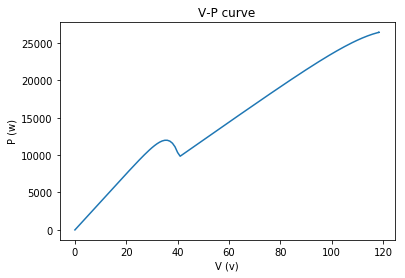

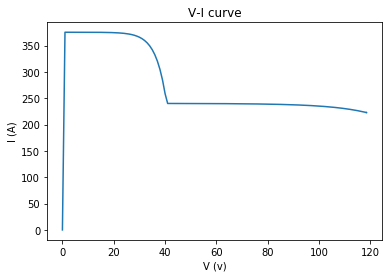

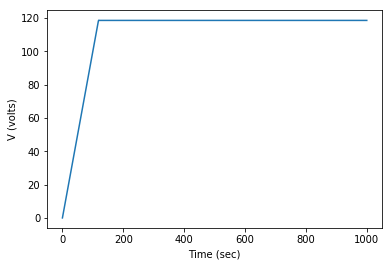

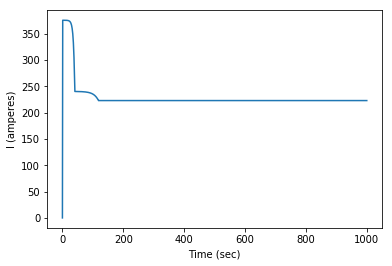

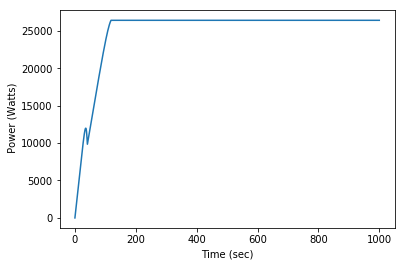

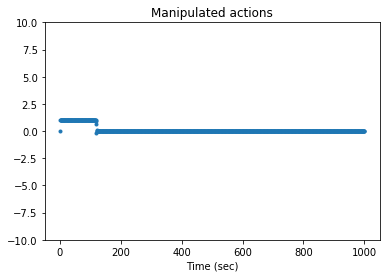

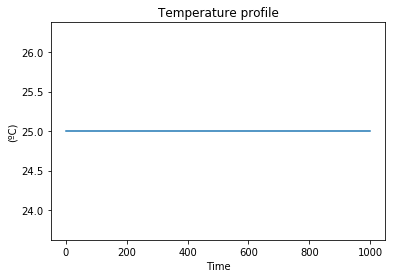

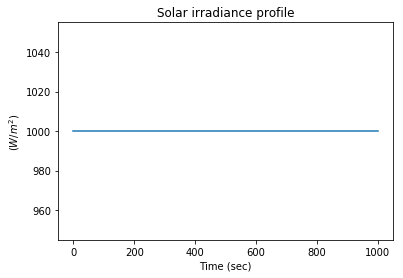

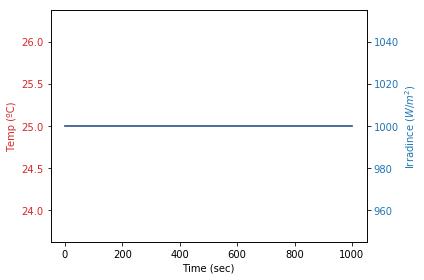

In [2]:
grafos.plotear()